In [1]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1050083629,1984,mfvsg,0.0,1,0,2,1
1,pub.1050083629,1984,svsg,0.0,1,1,1,1
2,pub.1091469564,1992,1972 random parasitoid model,0.0,1,0,1,1
3,pub.1117742847,2001,198697 lobster research cruise,0.0,1,0,1,1
4,pub.1043257859,2001,1986–97 lobster research cruise,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
18064866,pub.1000238039,2015,’s worker population size,0.0,1,40,1,1
18064867,pub.1005449634,2012,’s workforce swarm fraction depart,0.0,1,42,1,1
18064868,pub.1134463678,2021,’s bad crop pest,0.0,1,57,1,1
18064869,pub.1083920773,2017,’s bad invasive,0.0,1,54,1,1


In [4]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
18622,pub.1039451177,akh receptor,2002
18623,pub.1129686695,akh receptor,2020
18624,pub.1007326462,akh receptor,2006
18625,pub.1101015253,akh receptor,2018
49772,pub.1092160858,acromyrmex leaf cut ant,2017
...,...,...,...
18063221,pub.1010904311,γδ t cell,2012
18063223,pub.1039368032,γδ t cell,2014
18063225,pub.1120146611,γδ t cell,2019
18063226,pub.1040144066,γδ t cell,2012


In [5]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
concepts['inv_count'] = 1 / concepts['count']

concepts

,concept,year,count,norm_year,inv_count
0,abiotic factor,2013,7,0.920792,0.142857
1,abscisic acid,2010,4,0.891089,0.250000
2,absence of pollinator,2001,11,0.801980,0.090909
3,abundance of aphids,2007,4,0.861386,0.250000
4,abundance of arthropod,1984,6,0.633663,0.166667
...,...,...,...,...,...
4141,zebrafish brain,1991,4,0.702970,0.250000
4142,zebrafish larvae,2010,4,0.891089,0.250000
4143,zinc finger transcription factor,2002,5,0.811881,0.200000
4144,zooplankton biomass,1969,4,0.485149,0.250000


In [6]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
edges['inv_count'] = 1 / edges['count']

edges

,concept_source,concept_target,year,count,norm_year,inv_count
0,abiotic factor,abundance of insect,2015,1,0.940594,1.000000
1,abiotic factor,different insect pollinator,2015,1,0.940594,1.000000
2,abiotic factor,invertebrate community,2013,1,0.920792,1.000000
3,abiotic factor,non bee insect,2015,1,0.940594,1.000000
4,abiotic factor,non target invertebrate,2013,1,0.920792,1.000000
...,...,...,...,...,...,...
22851,worker bee,worker larvae,2020,1,0.990099,1.000000
22852,worker reproduction,worker sterility,2001,1,0.801980,1.000000
22853,worker reproduction,young larvae,2019,2,0.980198,0.500000
22854,xenopus tropicalis,zinc finger transcription factor,2013,1,0.920792,1.000000


In [7]:
# initialize the graph
G = nx.Graph()

# add the nodes
G.add_nodes_from([(c, {'norm_year': ny, 'inv_count': ic}) for c, ny, ic in zip(concepts['concept'], concepts['norm_year'], concepts['inv_count'])])

# add the edges
G.add_edges_from([(u, v, {'norm_year': ny, 'inv_count': ic}) for u, v, ny, ic in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'], edges['inv_count'])])

G

In [8]:
import oat_python as oat

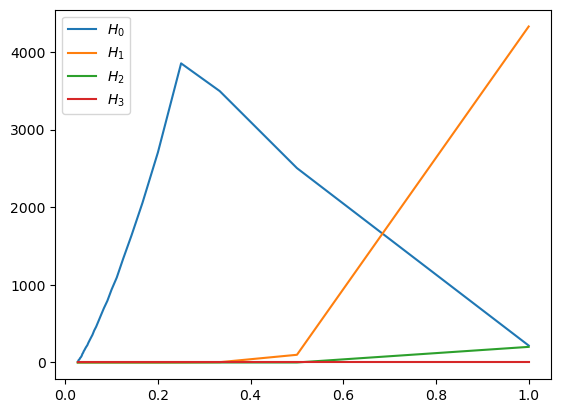

In [12]:
# config
max_dim = 3

# setup crocker
adj_year = nx.adjacency_matrix(G, weight='norm_year')
adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
adj_inv_count = adj_inv_count.sorted_indices()

# run crocker
years = np.unique(adj_year.data)
inv_counts = np.unique(adj_inv_count.data)
betti_curves = np.empty((len(years), len(inv_counts), max_dim + 1))

for i, y in enumerate(years):
    # zero out things not included
    y_adj = adj_inv_count.copy()
    y_adj[adj_year > y] = 0
    y_adj.eliminate_zeros()

    # calcaulte homology
    factored = oat.rust.FactoredBoundaryMatrixVr(y_adj, max_dim)
    homology = factored.homology(False, False)

    # create betti curve
    for d in range(max_dim + 1):
        dim_homology = homology[homology['dimension'] == d]  # get teh right dimensional features
        betti_curves[i, :, d] = ((dim_homology['birth'].values <= inv_counts[:, None]) &
                                (dim_homology['death'].values > inv_counts[:, None])).sum(axis=1)

plt.plot(inv_counts, betti_curves[-1], label=['$H_0$', '$H_1$','$H_2$','$H_3$'])
plt.legend()

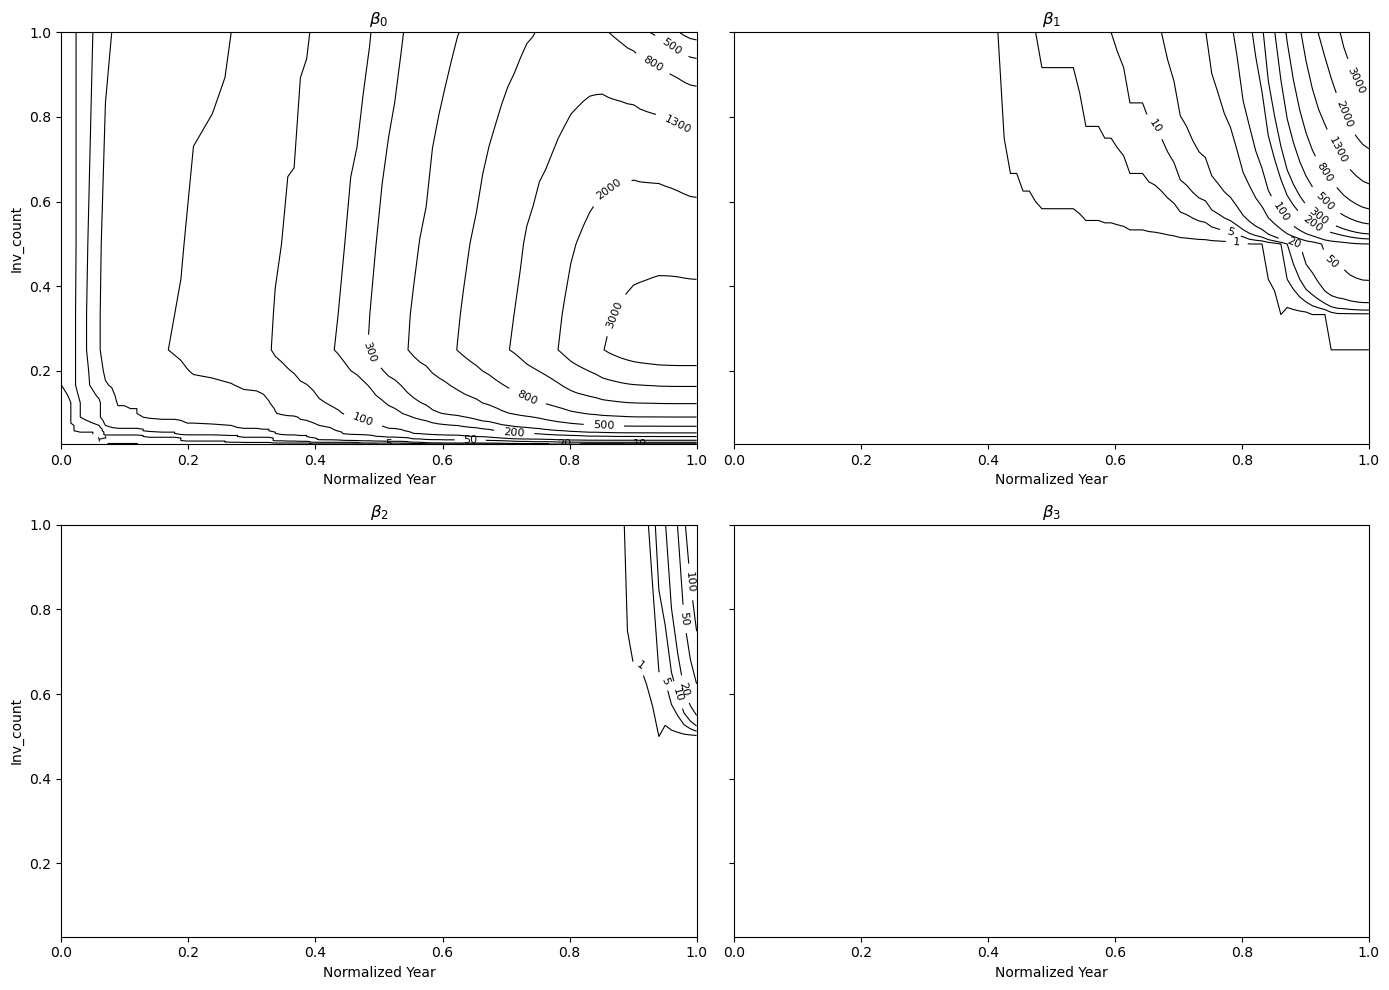

In [17]:
X, Y = np.meshgrid(years, inv_counts)

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for dim in range(4):
    row, col = divmod(dim, 2)
    ax = axs[row][col]

    Z = betti_curves[:, :, dim].T
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)

    if np.all(Z == Z[0, 0]):
        print(f"dim={dim} skipped: constant Z")
        continue

    cp = ax.contour(X, Y, Z, levels=[1, 5, 10, 20, 50, 100, 200, 300, 500, 800, 1300, 2000, 3000],
                    colors='black', linewidths=0.8)
    ax.clabel(cp, inline=True, fontsize=8)
    ax.set_xlabel("Normalized Year")
    ax.set_title(f"$\\beta_{dim}$")

axs[0][0].set_ylabel("Inv_count")
axs[1][0].set_ylabel("Inv_count")
plt.tight_layout()
plt.show()
